# Machine Learning II Project - Customer Segmentation


Group 17
- Joel Mendes - 20221825
- Lourenço Martins - 20222043
- Margarida Sardinha - 20221959

This project's goal is to segment a fictional retail company's customers into clusters, based on their demographic and purchasing data, and then create targeted promotions for each cluster detected.

This jupyter noteboook includes all functions and code that is required for our clustering solution, and that is the basis for the coupons and promotions created.

## Importing data and libraries

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Importing functions
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.spatial.distance import pdist

from preprocessing_py_files.preprocessing import *
from preprocessing_py_files.feature_engineering import *
from preprocessing_py_files.feature_selection import *

from visualization_py_files.initial_visualizations import *
from visualization_py_files.ploting import *

from modeling_py_files.dimensionality_reduction import *
from modeling_py_files.modeling import *
from modeling_py_files.association_rules import *

from extra_py_files.ExtraCredit import *
from extra_py_files.helping_functions import *

In [3]:
cust_basket = pd.read_csv('data/customer_basket.csv')
cust_info = pd.read_csv('data/customer_info.csv', index_col=0)
product_mapping = pd.read_excel('data/product_mapping.xlsx')

## Exploratory Data Analysis

The first step of any ML project is to clean and visualize the data one is working with. This, in our case, included creating variables and removing unwanted ones, scaling all numerical variables, and removing outliers, both random and those that form clusters a priori.

In [4]:
# Initial visualizations
display(cust_info.head())
display(cust_info.info())
display(cust_info.describe())
display(cust_info.describe(include=object))

display(cust_basket.head())
display(cust_basket.info())
display(cust_basket.describe())
display(cust_basket.describe(include=object))

product_mapping

,customer_id,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
0,39634,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,7106.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
1,43460,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,1334.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
2,23937,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,4073.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105
3,2431,Ora Boggess,female,06/15/1941 03:26 AM,0.0,0.0,0.0,1.0,10825.0,207.0,...,151.0,53.0,0.0,4135.0,70.0,0.215852,2007.0,958680.0,38.782169,-9.150318
4,10090,Lonnie Hopson,male,12/18/2001 03:03 AM,0.0,0.0,0.0,1.0,697.0,570.0,...,172.0,587.0,223.0,64.0,4.0,0.181023,2024.0,977059.0,38.770397,-9.177024


<class 'pandas.core.frame.DataFrame'>
Index: 43631 entries, 0 to 43630
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customer_id                              43631 non-null  int64  
 1   customer_name                            43631 non-null  object 
 2   customer_gender                          43631 non-null  object 
 3   customer_birthdate                       43631 non-null  object 
 4   kids_home                                43107 non-null  float64
 5   teens_home                               42610 non-null  float64
 6   number_complaints                        42977 non-null  float64
 7   distinct_stores_visited                  42322 non-null  float64
 8   lifetime_spend_groceries                 43631 non-null  float64
 9   lifetime_spend_electronics               43631 non-null  float64
 10  typical_hour                             41886 non-

None

,customer_id,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
count,43631.000000,43107.000000,42610.000000,42977.000000,42322.000000,43631.000000,43631.000000,41886.000000,42758.000000,43631.000000,...,42322.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,43631.000000,24654.000000,43631.000000,43631.000000
mean,24993.120877,1.081263,0.847829,0.705726,1.669959,5600.030047,2000.058468,13.520580,456.893938,443.636657,...,1471.423846,916.948408,990.334922,2023.225619,387.260182,0.229431,2011.342257,949808.661069,38.752266,-9.158591
std,14426.310863,1.239257,0.840397,0.624624,1.034825,4602.647746,3004.924537,4.558057,312.832282,210.313287,...,3910.163766,729.744050,1241.658577,2926.355387,411.436756,0.189242,4.656129,28894.251301,0.048629,0.036606
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.477986,1996.000000,900008.000000,38.690636,-9.418076
25%,12521.500000,0.000000,0.000000,0.000000,1.000000,2184.500000,218.000000,10.000000,227.000000,297.000000,...,187.000000,372.000000,204.000000,517.000000,97.000000,0.111704,2008.000000,924774.000000,38.732481,-9.175824
50%,24988.000000,1.000000,1.000000,1.000000,1.000000,4071.000000,574.000000,13.000000,387.000000,419.000000,...,641.000000,668.000000,557.000000,874.000000,252.000000,0.205235,2011.000000,949681.000000,38.748887,-9.160152
75%,37484.500000,1.000000,1.000000,1.000000,2.000000,6605.500000,2565.500000,17.000000,584.000000,560.000000,...,1570.000000,1437.000000,1111.000000,2217.000000,537.000000,0.310884,2014.000000,975117.250000,38.764504,-9.139240
max,50000.000000,9.000000,6.000000,9.000000,8.000000,26552.000000,21273.000000,24.000000,2112.000000,2224.000000,...,50381.000000,3487.000000,5389.000000,19596.000000,3544.000000,1.196858,2024.000000,999996.000000,39.357600,-9.055377


,customer_name,customer_gender,customer_birthdate
count,43631,43631,43631
unique,42351,2,43594
top,James Brown,female,08/13/1962 08:48 PM
freq,10,21910,2


,invoice_id,list_of_goods,customer_id
0,7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
1,3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
2,10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134
3,12179179,"['babies food', 'milk', 'rice', 'yogurt cake',...",43134
4,8292388,"['napkins', 'cookies', 'razor', 'cooking oil',...",43134


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89952 entries, 0 to 89951
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   invoice_id     89952 non-null  int64 
 1   list_of_goods  89952 non-null  object
 2   customer_id    89952 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


None

,invoice_id,customer_id
count,8.995200e+04,89952.000000
mean,6.126259e+06,21855.193915
std,3.527265e+06,12610.661213
min,2.006600e+04,1.000000
25%,3.085110e+06,10814.000000
50%,6.133909e+06,21904.000000
75%,9.185876e+06,32771.000000
max,1.224224e+07,43631.000000


,list_of_goods
count,89952
unique,88767
top,"['babies food', 'cooking oil']"
freq,25


,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks
3,dessert wine,alcohol_drinks
4,french wine,alcohol_drinks
...,...,...
160,final fantasy XX,videogames
161,final fantasy XIX,videogames
162,final fantasy XXII,videogames
163,dog food,pet food


#### Inconsistencies found

In [5]:
# Variables with missing values
cust_info.isnull().sum()

customer_id                                    0
customer_name                                  0
customer_gender                                0
customer_birthdate                             0
kids_home                                    524
teens_home                                  1021
number_complaints                            654
distinct_stores_visited                     1309
lifetime_spend_groceries                       0
lifetime_spend_electronics                     0
typical_hour                                1745
lifetime_spend_vegetables                    873
lifetime_spend_nonalcohol_drinks               0
lifetime_spend_alcohol_drinks                  0
lifetime_spend_meat                            0
lifetime_spend_fish                         1309
lifetime_spend_hygiene                         0
lifetime_spend_videogames                      0
lifetime_spend_petfood                         0
lifetime_total_distinct_products               0
percentage_of_produc

In [6]:
# A percentage cannot be negative
cust_info['percentage_of_products_bought_promotion'].min()

-0.4779855680623625

## Preprocessing

#### 1. Engineering of interesting variables

In [4]:
cust_info_pp = custinfo_feature_eng(cust_info)

Added columns: age, gender, loyalty_program, education, vegetarian, lifetime_total_spent.
Droped columns: customer_birthdate, customer_gender, loyalty_card_number.



In [25]:
cust_info_pp.head()

,customer_name,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,age,gender,loyalty_program,education,vegetarian,lifetime_total_spent
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,484.0,604.0,...,0.072206,2010.0,38.735637,-9.149071,60,0,False,12,0,42391.0
43460,Belinda Terry,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,344.0,374.0,...,0.206227,2014.0,38.762702,-9.160802,36,1,False,12,0,18973.0
23937,Evelyn Calico,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,301.0,852.0,...,0.136168,2009.0,38.717431,-9.165105,55,1,True,12,0,18957.0
2431,Ora Boggess,0.0,0.0,0.0,1.0,10825.0,207.0,17.0,153.0,252.0,...,0.215852,2007.0,38.782169,-9.150318,83,1,True,12,0,16191.0
10090,Lonnie Hopson,0.0,0.0,0.0,1.0,697.0,570.0,NaN,8.0,33.0,...,0.181023,2024.0,38.770397,-9.177024,22,0,True,12,0,5245.0


In [5]:
# Applying the preproc functions to customer_basket
basket_treated = cust_basket_preproc(cust_basket)
basket_encoded = cust_basket_encoding(basket_treated)

#### 2. Uni Dimensional Outliers Identification

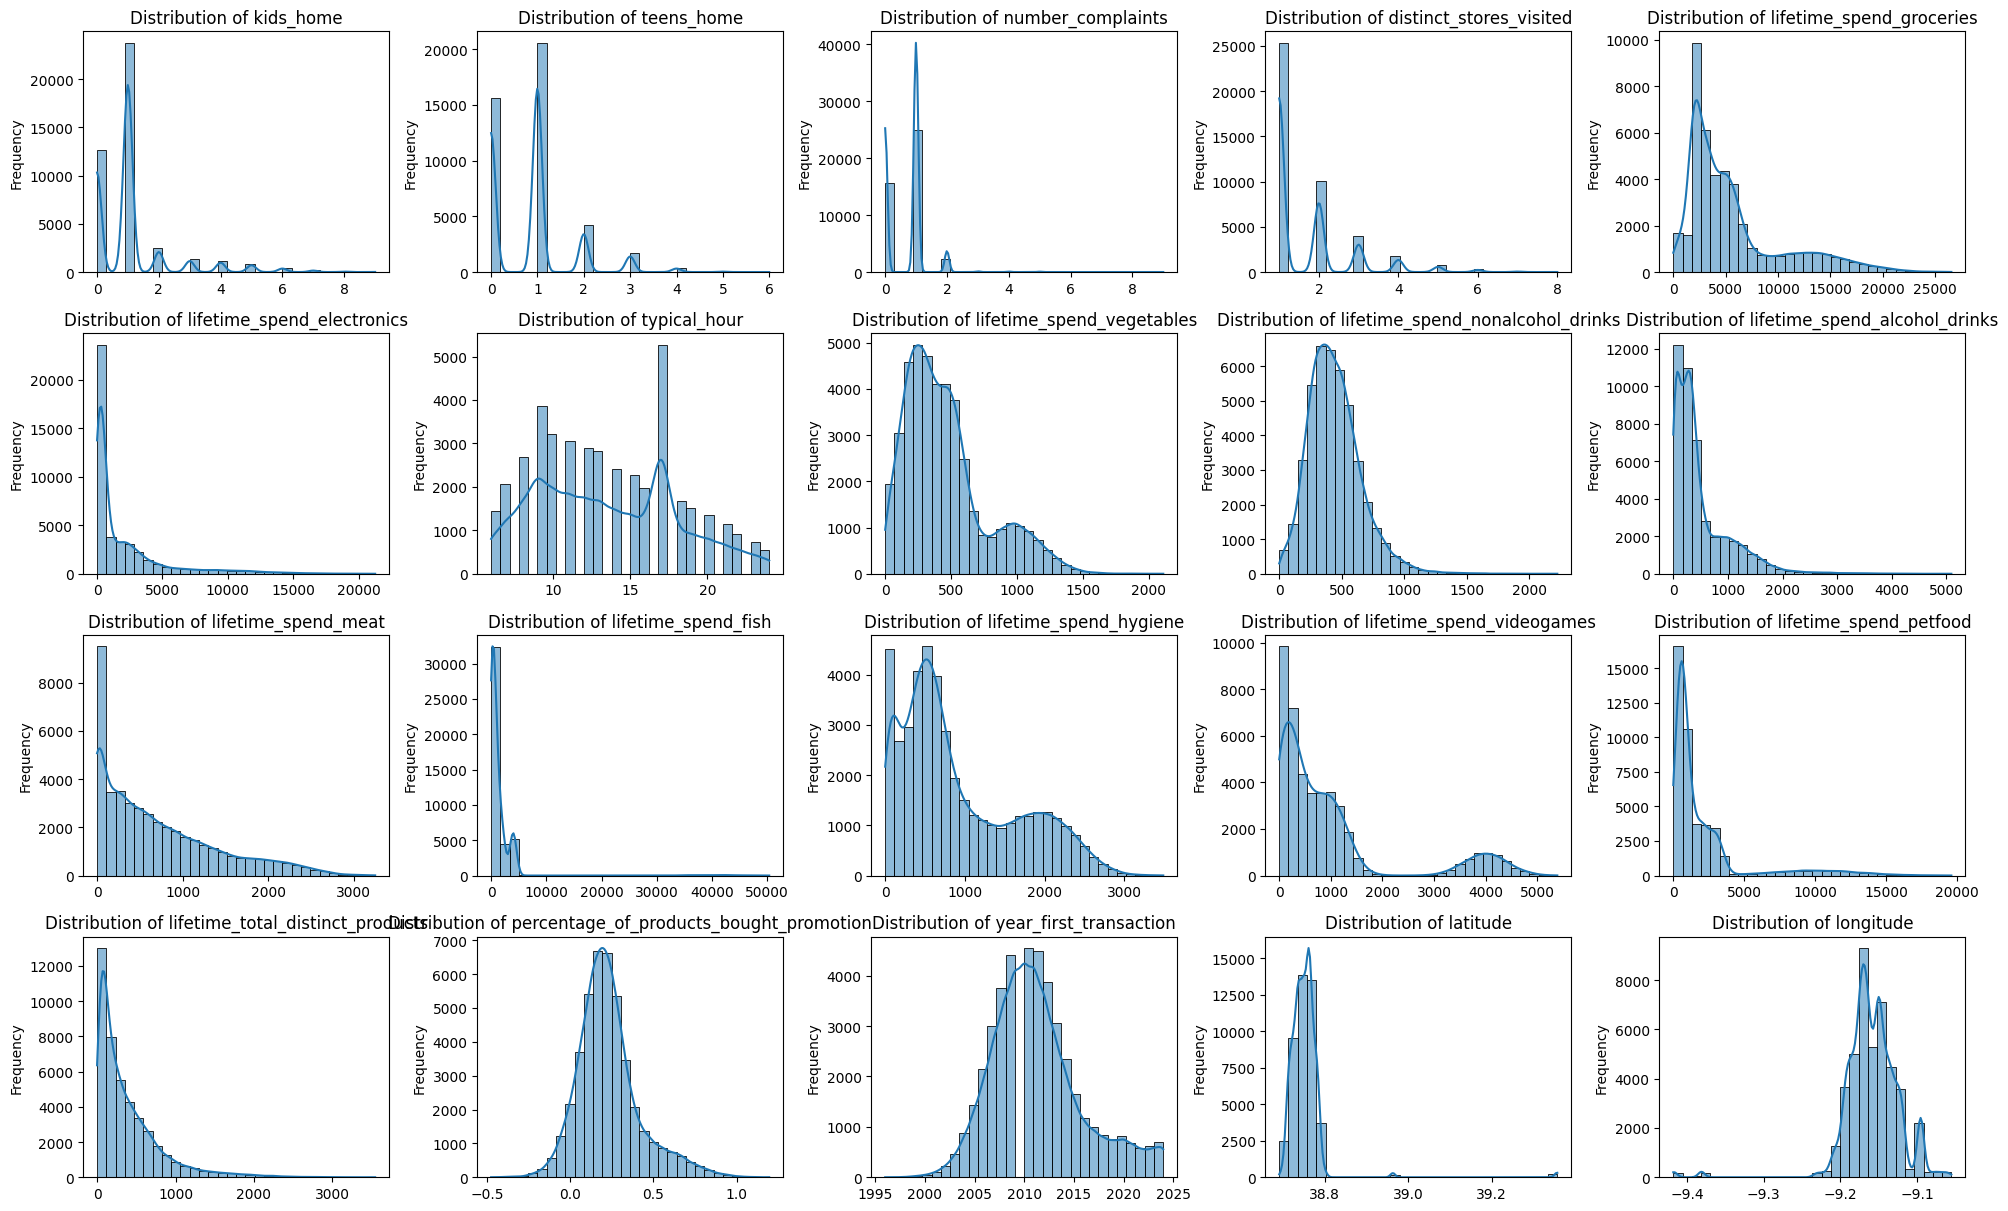

In [27]:
plot_distributions_grid(cust_info, cols_to_drop=['customer_id', 'customer_name', 'loyalty_card_number', 'customer_birthdate', 'customer_gender'], 
                        figsize=(20, 15), bins=30)

Variables in need of further investigatigation:
- lifetime_spend_fish
- lifetime_spend_videogames
- lifetime_spend_petfood
- latitude and longitude

Starting with coordinates, let's identify why there is a group of people very distant from the rest.

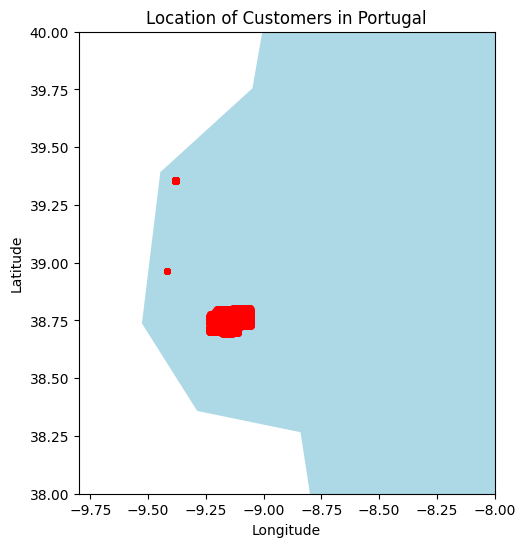

In [11]:
plot_population(cust_info)

In [6]:
fish_apriori, men_of_the_sea = find_fishermen(cust_info_pp)

In [7]:
compare(fish_apriori, men_of_the_sea)

,df1_means,df2_means
kids_home,1.0,0.0
teens_home,1.0,0.0
number_complaints,1.0,1.0
distinct_stores_visited,2.0,1.0
lifetime_spend_groceries,5526.0,13855.0
lifetime_spend_electronics,2016.0,187.0
typical_hour,14.0,10.0
lifetime_spend_vegetables,457.0,406.0
lifetime_spend_nonalcohol_drinks,445.0,308.0
lifetime_spend_alcohol_drinks,498.0,100.0


As we can see men of the sea (clients whose location is close to the ocean) do not have much relevant information, besides that they buy a lot of fish, this is group of simillar unidimensional outliers that belong to our first cluster.

#### 3. Multi-dimensional Outliers Analysis

For multi dimensional outliers we will run a KMeans algorithm with a large K which will make it more prone to identify groups of similar clients very differentiable from the rest.

In [8]:
# create test_outliers variable to store the data without fisherman for initial outlier analysis or possibly more apriori clusters
test_outliers = fish_apriori.copy()
test_outliers_train = test_outliers.drop(columns=['customer_name', 'latitude', 'longitude', 'loyalty_program'])

# run the functions that make the data ready for cluster analysis
imputation(test_outliers_train, test_outliers_train.select_dtypes(include=[np.number]).columns)
scaling(test_outliers_train, test_outliers_train.select_dtypes(include=[np.number]).columns)

test_outliers_train.head(3)

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,age,gender,education,vegetarian,lifetime_total_spent
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0.0,0.0,0.0,1.0,3.307318,2.747998,0.571429,0.270423,0.695817,1.229703,...,3.731788,0.953189,-0.509091,-0.695177,-0.166667,0.258065,-1.0,0.0,0.0,2.365362
43460,0.0,-1.0,0.0,1.0,0.229273,0.315634,-0.714286,-0.123944,-0.178707,1.772277,...,0.511038,0.644822,5.250000,0.003924,0.500000,-0.516129,0.0,0.0,0.0,0.489446
23937,-1.0,0.0,0.0,2.0,-0.214914,1.469869,-0.428571,-0.245070,1.638783,2.790099,...,1.036424,0.662961,2.331818,-0.361527,-0.333333,0.096774,0.0,0.0,0.0,0.488164


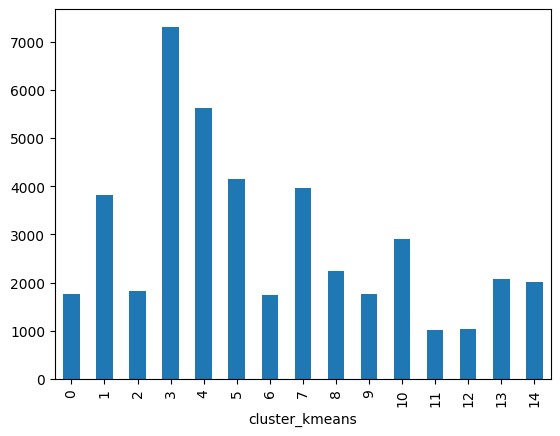

In [18]:
allocate_clusters_kmeans(test_outliers, test_outliers_train, n_clusters=15, random_state=42)
test_outliers.groupby(['cluster_kmeans']).size().plot(kind='bar')
plt.show()

In [12]:
# analysing the smaller clusters, that are the more prone to being pushed by outliers
show_clusters(test_outliers, 'cluster_kmeans', [7,10,13])

Cluster 7 size: 1029
Cluster 10 size: 1097
Cluster 13 size: 721
Overall dataset size: 43243


,Overall Mean,Cluster 7 Mean,Cluster 10 Mean,Cluster 13 Mean
kids_home,1.09,0.32,1.00,3.71
teens_home,0.86,0.03,0.99,2.09
number_complaints,0.71,0.03,0.50,1.03
distinct_stores_visited,1.68,1.39,1.39,1.12
lifetime_spend_groceries,5525.97,917.70,14231.66,5037.34
lifetime_spend_electronics,2016.32,500.54,9238.56,2006.62
typical_hour,13.55,18.72,13.57,17.84
lifetime_spend_vegetables,457.35,102.47,504.94,503.34
lifetime_spend_nonalcohol_drinks,444.85,518.47,595.18,508.20
lifetime_spend_alcohol_drinks,497.61,2135.19,999.22,305.70


Analysing the values of the 3 smallest clusters, 3 and 7 are close so they will stay in the model, although cluster number 8 is really interesting.

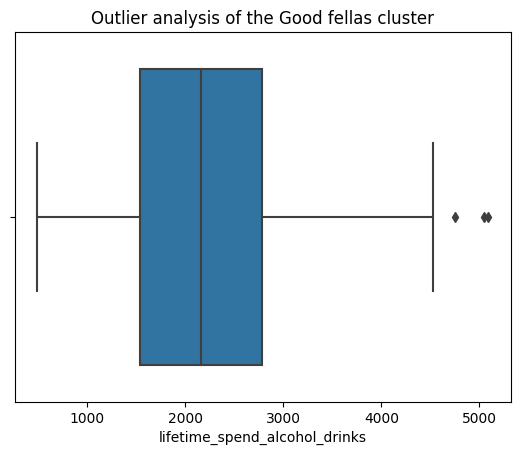

In [15]:
spend_alchool = test_outliers[test_outliers['cluster_kmeans'] == 8]["lifetime_spend_alcohol_drinks"] 

plt.figure()
sns.boxplot(x = spend_alchool)
plt.xlabel('lifetime_spend_alcohol_drinks')
plt.title('Outlier analysis of the Good fellas cluster')
plt.show()

A second group of very similar clients was identified. With small values accross the other variables, lifetime_spend_alcohol_drinks stands out drastically in this group as well as age.  
In an effort to know if this observations were closer to the average population but were being pulled away by outliers, we plotted this boxplot that proves the contrary. This is a very concise group of young alchoolics. Our second cluster.

In [23]:
# stores the apriori cluster of alchoolics (which we assume is students)
uni_students = test_outliers[test_outliers['cluster_kmeans'] == 8]

# stores the rest of the observations that do not belong to fisherman and uni students
cust_info_sep = test_outliers[test_outliers['cluster_kmeans'] != 8]

In [24]:
cust_info_sep.drop('cluster_kmeans', axis=1, inplace=True)

Prepared Dataframes for future use:
- *cust_info:* Original dataset
- *cust_info_pp:* Original but preprosseced dataset
- *cust_info_sep:* Preprocessed dataset without fishermen and uni removed
- *fisherman:* Cluster of fishermans
- *uni_students:* Cluster of university students
- *basket_treated:* Cleaned up, to serve as reference if needed
- *basket_encoded:* With TransactionEncoded applied, to be used for association rules

#### 4. Feature Selection

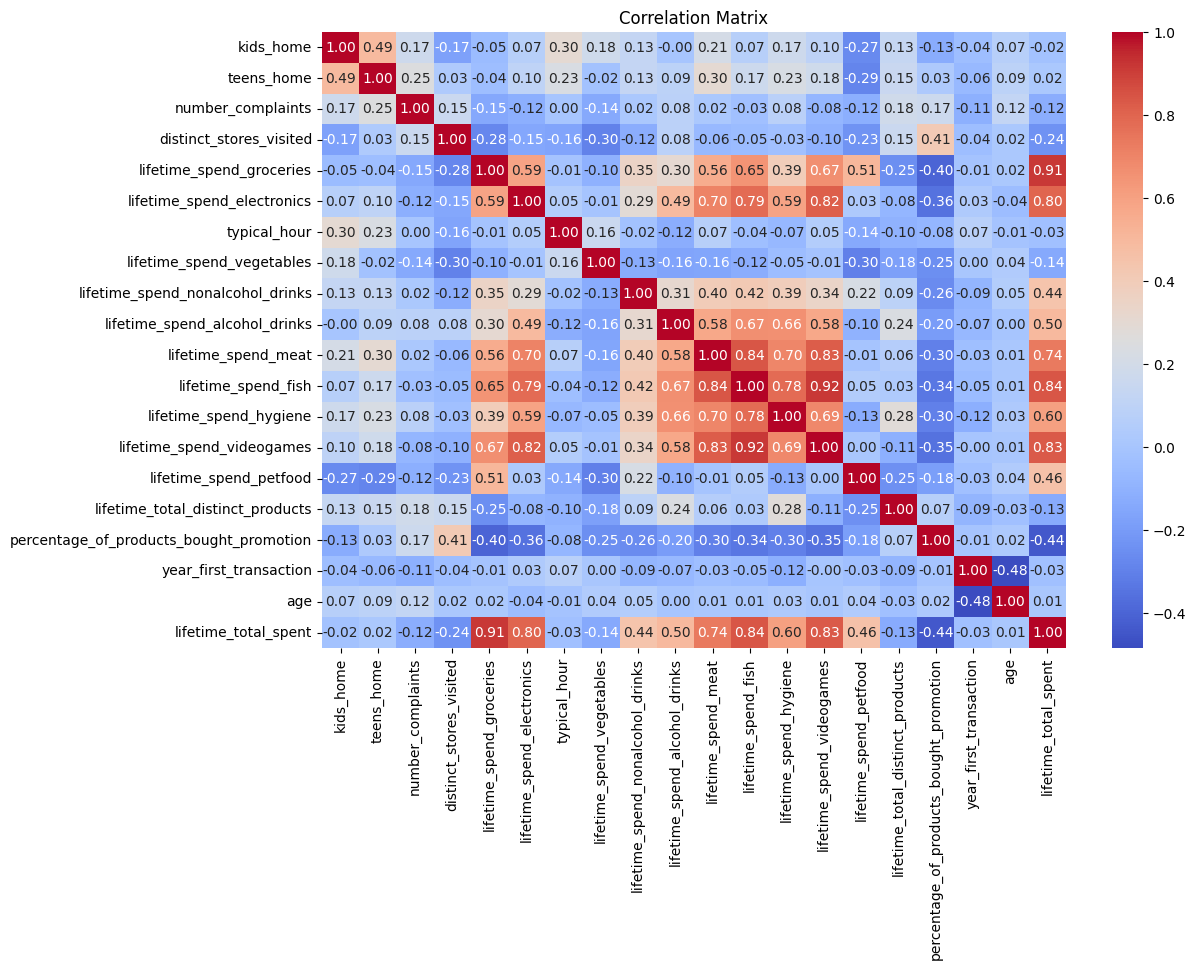

In [33]:
plot_variable_correlation(cust_info_sep, ['customer_name', 'education', 'gender', 'loyalty_program',
                                          'latitude', 'longitude', 'vegetarian'])

Based on the results above, here we remove the unwanted features, those that were too highly correlated and thus worked as proxies for another.

In [21]:
cust_info_pp = feature_selection(cust_info_pp)

#### 5. Scalling and Imputation

In [25]:
cust_info_sep_sc = scaling_imputation(cust_info_sep)
cust_info_pp_sc = scaling_imputation(cust_info_pp)

### Final Dataframes description:
- *cust_info:* Original dataset
- *cust_info_pp:* Original but preprosseced dataset (feature engineering and selection)

- *cust_info_sep:* Preprocessed dataset without fishermen and uni removed
- *fisherman:* Cluster of fishermans
- *uni_students:* Cluster of university students

- *cust_info_pp_sc:* All observations preprosseced and scaled
- *cust_info_sep_sc:* Non-apriori clusters preprosseced and scaled

- *basket_treated:* Cleaned up, to serve as reference if needed
- *basket_encoded:* With TransactionEncoded applied, to be used for association rules

## Customer Segmentation

### Preparing the data

To apply to the clustering algorithms, only the variables relating to purchase history will be used.

The initial plan was to create 2 clustering solutions and merge them based on results, but due to time constraints, only the most relevant variables, the ones relating to purchase history, will be used. In future, the project could be expanded upon by utilizing the demographic variables as well.

In [26]:
cust_info_pp_sc = modelling_separator(cust_info_pp_sc)
cust_info_sep_sc = modelling_separator(cust_info_sep_sc)

### K-Means Clustering

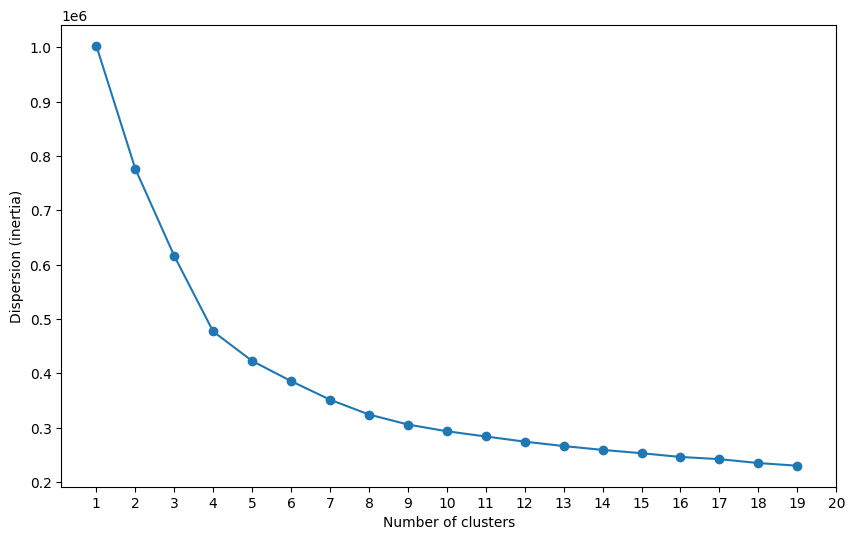

In [43]:
# Checking the optimum number of clusters to look for
dispersion = create_dispersion_list(cust_info_sep_sc)
plot_elbow_graph(dispersion)

In [27]:
allocate_clusters_kmeans(cust_info_sep, cust_info_sep_sc, n_clusters=4)

In [28]:
show_clusters(cust_info_sep, cluster_column='cluster_kmeans', cluster_numbers=[0,1,2,3])

Cluster 0 size: 4144
Cluster 1 size: 23259
Cluster 2 size: 5618
Cluster 3 size: 7978
Overall dataset size: 40999


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean
kids_home,0.88,0.00,0.91,1.00,1.17
teens_home,0.79,0.01,0.89,1.00,0.77
number_complaints,0.69,0.51,0.78,0.50,0.66
distinct_stores_visited,1.71,1.00,1.95,1.39,1.58
lifetime_spend_groceries,5552.20,10187.26,3243.06,14032.19,3905.15
lifetime_spend_electronics,2015.79,159.83,1037.84,8143.21,1516.11
typical_hour,13.33,11.85,13.44,13.64,13.53
lifetime_spend_vegetables,454.99,198.32,447.29,499.65,579.53
lifetime_spend_nonalcohol_drinks,441.57,499.00,408.26,597.00,399.42
lifetime_spend_alcohol_drinks,508.34,40.36,500.42,1013.67,418.66


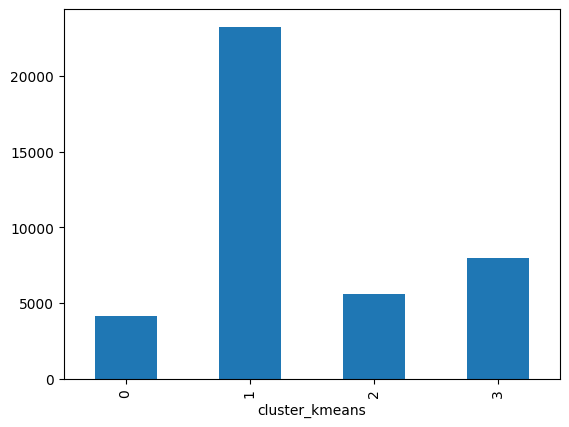

In [31]:
plot_cluster_sizes(cust_info_sep, 'cluster_kmeans')

### Hierarchical Clustering

In [51]:
cust_info_sc_new = cust_info_sep_sc.copy()

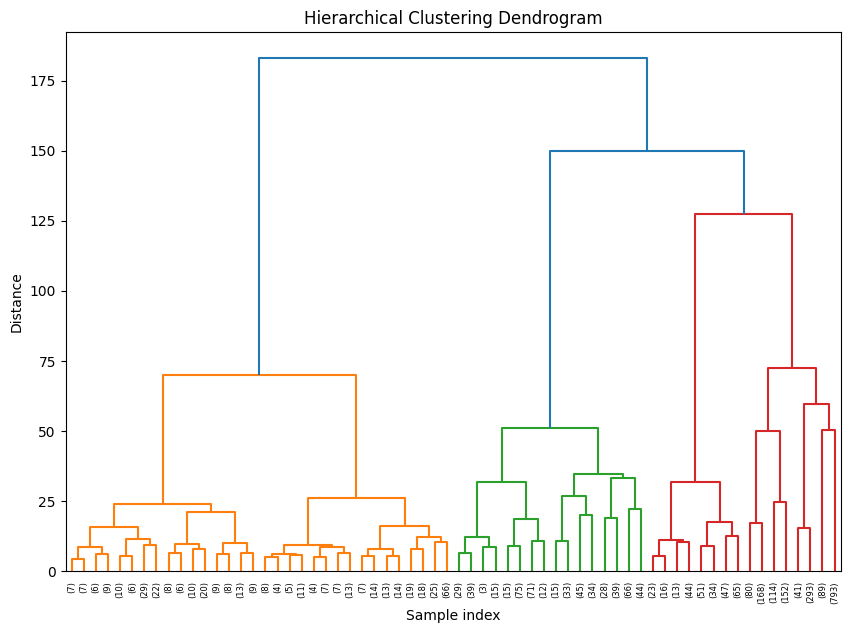

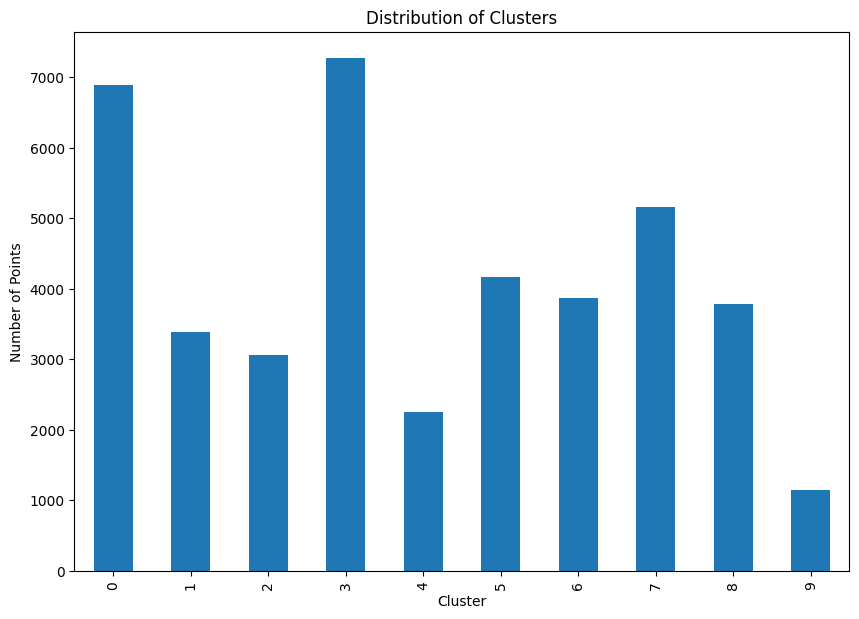

In [52]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming cust_info_sc is your scaled DataFrame
# Sample the data
sampled_df = cust_info_sc_new.sample(n=3000, random_state=42)  # Adjust 'n' as needed

# Perform hierarchical clustering
Z = linkage(sampled_df, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Specify the number of clusters
k = 10
clusters = fcluster(Z, k, criterion='maxclust')

# Add cluster labels to the sampled DataFrame
sampled_df['Cluster'] = clusters

# Prepare data for training KMeans
X_sampled = sampled_df.drop(columns=['Cluster'])

# Train a KMeans model
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_sampled)

# Predict cluster labels for the entire data
full_clusters = kmeans.predict(cust_info_sc_new)

# Add predicted cluster labels to the entire DataFrame
cust_info_sc_new['Cluster'] = full_clusters

# Plot the distribution of clusters
plt.figure(figsize=(10, 7))
cust_info_sc_new['Cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Points')
plt.show()



In [61]:
show_clusters(cust_info_sc_new, 'Cluster', [0,1,2,3,4,5,6,7,8,9])

Cluster 0 size: 6888
Cluster 1 size: 3385
Cluster 2 size: 3063
Cluster 3 size: 7282
Cluster 4 size: 2257
Cluster 5 size: 4175
Cluster 6 size: 3866
Cluster 7 size: 5162
Cluster 8 size: 3781
Cluster 9 size: 1140
Overall dataset size: 40999


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean,Cluster 7 Mean,Cluster 8 Mean,Cluster 9 Mean
lifetime_spend_groceries,0.38,-0.39,2.24,-0.19,0.06,2.25,1.40,0.27,-0.21,0.14,-0.64
lifetime_spend_electronics,0.63,-0.10,3.21,-0.05,0.53,3.23,-0.16,0.68,-0.05,0.78,-0.01
lifetime_spend_vegetables,0.22,-0.38,0.34,1.61,0.07,0.35,-0.48,-0.20,1.63,-0.10,-0.72
lifetime_spend_nonalcohol_drinks,0.11,-0.36,0.68,-0.40,0.17,0.69,0.32,0.68,-0.36,0.11,0.42
lifetime_spend_alcohol_drinks,0.32,0.05,1.20,-0.33,0.11,1.24,-0.50,1.23,-0.28,0.45,2.90
lifetime_spend_meat,0.22,-0.07,1.63,-0.49,0.34,1.62,-0.32,0.52,-0.45,0.34,-0.32
lifetime_spend_fish,0.37,-0.06,2.39,-0.39,0.20,2.39,-0.28,0.94,-0.36,0.42,-0.26
lifetime_spend_hygiene,0.24,-0.13,1.20,-0.14,0.17,1.21,-0.51,1.17,-0.14,0.42,-0.12
lifetime_spend_videogames,0.53,-0.12,3.87,-0.33,0.34,3.87,-0.58,0.53,-0.32,0.42,-0.22
lifetime_spend_petfood,0.67,-0.15,1.17,-0.19,0.01,1.17,5.07,0.59,-0.18,0.16,-0.39


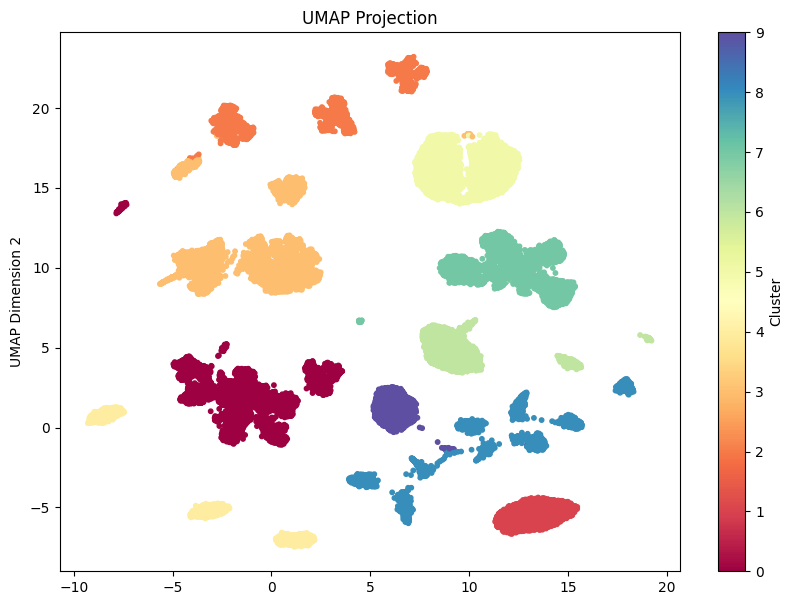

In [60]:
def apply_umap2(dataset, cluster_column='cluster_kmeans'):
    '''
    Function to visualize clusters through UMAP
    '''
    umap_model = umap.UMAP(n_neighbors=15, min_dist=0.3, n_components=2, random_state=0)

    # Step 2: Fit and transform the data
    umap_embeddings = umap_model.fit_transform(dataset)

    # Step 3: Add UMAP embeddings to the DataFrame
    '''Assuming modeldf_purchase is a DataFrame'''
    dataset['umap_1'] = umap_embeddings[:, 0]
    dataset['umap_2'] = umap_embeddings[:, 1]
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(dataset['umap_1'], dataset['umap_2'], 
                        c=dataset[cluster_column], cmap='Spectral', s=10)

    '''Adding labels to the clusters'''
    for cluster in set(dataset[cluster_column]):
        plt.scatter([], [], c=scatter.cmap(scatter.norm(cluster)), label=f'Cluster {cluster}')

    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Projection')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
apply_umap2(cust_info_sc_new, 'Cluster')

In [ ]:
pd.DataFrame(
    confusion_matrix(info_treated.cluster_kmeans, info_treated.cluster_hierarchical),
    index = ['K-means {} Cluster'.format(i) for i in np.arange(0,8)],
    columns = ['Ward {} Cluster'.format(i) for i in np.arange(0,8)],
)

In [ ]:
modeldf_purchase.groupby(['cluster_hierarchical']).size().plot(kind='bar')
plt.show()

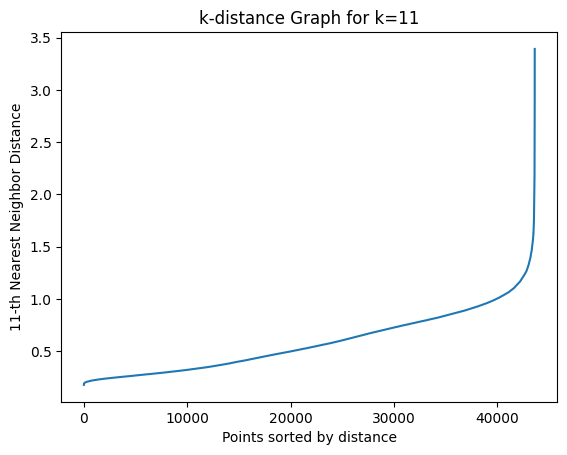

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X, k):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    plt.plot(distances)
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th Nearest Neighbor Distance')
    plt.title(f'k-distance Graph for k={k}')
    plt.show()

# Plot the k-distance graph
plot_k_distance(modeldf_purchase, k=11)

In [16]:
from scipy.spatial import distance_matrix

# Calculate the distance matrix
dist_matrix = distance_matrix(modeldf_purchase, modeldf_purchase)

# Summary statistics of pairwise distances
print('Min distance:', np.min(dist_matrix))
print('Max distance:', np.max(dist_matrix))
print('Mean distance:', np.mean(dist_matrix))
print('Median distance:', np.median(dist_matrix))

Min distance: 0.0
Max distance: 38.29788327327018
Mean distance: 4.607739242156588
Median distance: 3.796718062079621


### DBSCAN

In [19]:
eps_range = np.arange(0.7, 1.2, 0.1)
min_samples_range = range(10, 40, 5)

# Function to calculate and print cluster sizes and noise points
def print_cluster_info(labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    cluster_info = dict(zip(unique_labels, counts))

    noise_points = cluster_info.get(-1, 0)
    clusters = {k: v for k, v in cluster_info.items() if k != -1}

    return clusters, noise_points

# Grid search over the parameter ranges
for min_samples in min_samples_range:
    for eps_val in eps_range:
        model = DBSCAN(eps=eps_val, min_samples=min_samples)
        labels = model.fit_predict(modeldf_purchase)

        clusters, noise_points = print_cluster_info(labels)

        if noise_points <= 5000:
            print(f'eps: {round(eps_val,2)}, min_samples: {min_samples}')
            print(f'Cluster sizes: {clusters}')
            print(f'Number of noise points: {noise_points}')
            print('-' * 40)

eps: 0.9, min_samples: 10
Cluster sizes: {0: 4637, 1: 36383, 2: 340, 3: 13, 4: 11, 5: 6}
Number of noise points: 2241
----------------------------------------
eps: 1.0, min_samples: 10
Cluster sizes: {0: 5202, 1: 37065, 2: 357}
Number of noise points: 1007
----------------------------------------
eps: 1.1, min_samples: 10
Cluster sizes: {0: 42778, 1: 361}
Number of noise points: 492
----------------------------------------
eps: 0.9, min_samples: 15
Cluster sizes: {0: 4250, 1: 4230, 2: 31784, 3: 318, 4: 6}
Number of noise points: 3043
----------------------------------------
eps: 1.0, min_samples: 15
Cluster sizes: {0: 5057, 1: 36878, 2: 343}
Number of noise points: 1353
----------------------------------------
eps: 1.1, min_samples: 15
Cluster sizes: {0: 42628, 1: 353}
Number of noise points: 650
----------------------------------------
eps: 0.9, min_samples: 20
Cluster sizes: {0: 3795, 1: 4214, 2: 31493, 3: 278}
Number of noise points: 3851
----------------------------------------
eps

In [21]:
allocate_clusters_dbscan(info_treated, modeldf_purchase, eps=1, min_samples=30)

info_treated.select_dtypes(include=[np.number]).groupby(['cluster_dbscan']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,age,gender,education,vegetarian,lifetime_total_spent,cluster_kmeans
cluster_dbscan,,,,,,,,,,,,,,,,,,,,,
-1,-0.073413,-0.154365,-0.205317,0.672302,1.119907,1.836657,-0.038220,0.256519,0.748042,1.440738,...,-0.184492,-0.007275,0.667674,-0.125810,0.082873,-0.483730,1.378175,0.000000,1.175304,2.688889
0,0.001606,-0.005085,-0.504505,0.386128,2.252727,3.120469,0.090748,0.314890,0.686748,1.335949,...,-0.601856,0.024978,0.096394,0.379237,0.086537,-0.503122,2.010036,0.000000,2.049855,1.020517
1,-1.000000,-0.987962,-0.495498,0.000000,1.374022,-0.176423,-0.161774,-0.528306,0.303863,-0.558149,...,-0.033560,0.008649,-0.005516,-0.372761,0.090216,-0.494076,0.000000,0.000000,0.678524,3.954976
2,0.254299,-0.056160,-0.244008,0.803161,-0.131145,0.269778,0.115976,0.272262,-0.063864,0.249180,...,0.332938,0.073077,-0.028557,0.117145,-0.007709,-0.498569,1.198700,0.030363,-0.228020,2.650977
3,-0.963636,-0.974747,-0.480808,0.000000,2.221648,-0.167916,-0.406061,-0.055700,-0.379364,-0.443144,...,1.051855,0.049663,12.773199,-6.539337,0.079505,-0.545455,0.025253,0.000000,3.367227,2.000000
4,-0.984615,-0.950769,-0.581538,0.000000,2.214125,-0.147686,-0.529670,-0.158285,-0.486341,-0.428957,...,0.864780,-0.002564,13.873239,-6.451836,0.042680,-0.415385,0.046154,0.000000,2.962590,2.000000


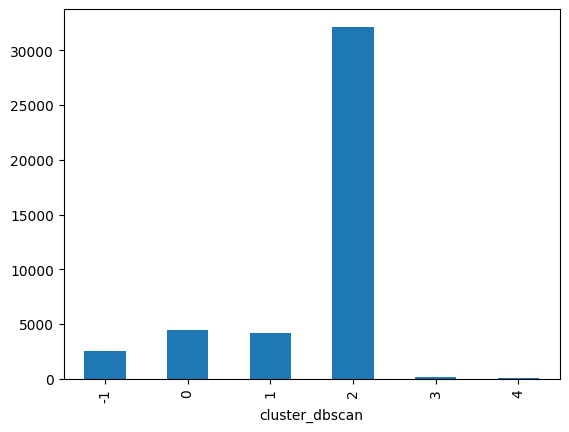

In [22]:
info_treated.groupby(['cluster_dbscan']).size().plot(kind='bar')
plt.show()

### Meanshift

In [23]:
from sklearn.cluster import estimate_bandwidth

estimate_bandwidth(modeldf_purchase, quantile=0.15)

KeyboardInterrupt: 

In [ ]:
allocate_clusters_meanshift(info_treated, modeldf_purchase, bandwidth=4)

In [ ]:
info_treated.select_dtypes(include=[np.number]).groupby(['cluster_meanshift']).mean()

In [ ]:
info_treated.groupby(['cluster_meanshift']).size().plot(kind='bar')
plt.show()

### Segment Descriptions

In [56]:
solution = pd.concat([cust_info_sep.reset_index()[['customer_id', 'cluster_kmeans']],
                      fishermen.reset_index()[['customer_id']].assign(cluster_kmeans='men_of_the_sea'),
                      uni_students.reset_index()[['customer_id']].assign(cluster_kmeans='good_fellas')],
                      ignore_index=True)

#solution.to_csv('final_solution.csv')
solution

,customer_id,cluster_kmeans
0,39634,3
1,43460,1
2,23937,1
3,2431,0
4,24058,3
...,...,...
43626,40730,good_fellas
43627,9563,good_fellas
43628,45096,good_fellas
43629,11458,good_fellas


In [60]:
cols = cust_info_sep_sc.columns
cols = cols.drop(['lifetime_total_spent', 'education', 'age'])

In [61]:
cust_info_cols = list(cols)
cust_info_cols.append('cluster_kmeans')

In [62]:
cust_info_clust = cust_info_sep[cust_info_cols]

fishermen_clust = fishermen[cols].copy()
fishermen_clust['cluster_kmeans'] = 5

good_fellas_clust = uni_students[cols].copy()
good_fellas_clust['cluster_kmeans'] = 6

In [63]:
model_df_with_clusters_apriori = pd.concat([cust_info_clust,
                                            fishermen_clust,
                                            good_fellas_clust], 
                                            ignore_index=True)

In [64]:
show_clusters(model_df_with_clusters_apriori, 'cluster_kmeans', list(range(0,10)))

Cluster 0 size: 4148
Cluster 1 size: 24529
Cluster 2 size: 7966
Cluster 3 size: 5624
Cluster 4 size: 0
Cluster 5 size: 388
Cluster 6 size: 976
Cluster 7 size: 0
Cluster 8 size: 0
Cluster 9 size: 0
Overall dataset size: 43631


,Overall Mean,Cluster 0 Mean,Cluster 1 Mean,Cluster 2 Mean,Cluster 3 Mean,Cluster 4 Mean,Cluster 5 Mean,Cluster 6 Mean,Cluster 7 Mean,Cluster 8 Mean,Cluster 9 Mean
lifetime_spend_groceries,5600.03,10185.86,3495.91,3912.22,14029.00,NaN,13854.64,915.32,NaN,NaN,NaN
lifetime_spend_electronics,2000.06,159.81,1148.69,1519.60,8136.29,NaN,187.31,501.08,NaN,NaN,NaN
lifetime_spend_vegetables,456.89,198.27,465.57,581.02,499.59,NaN,405.79,102.73,NaN,NaN,NaN
lifetime_spend_nonalcohol_drinks,443.64,498.93,412.21,399.42,596.85,NaN,308.46,530.21,NaN,NaN,NaN
lifetime_spend_alcohol_drinks,494.07,40.35,416.76,410.21,1013.97,NaN,99.83,2210.93,NaN,NaN,NaN
lifetime_spend_meat,709.37,202.13,586.57,531.83,2003.92,NaN,84.28,189.20,NaN,NaN,NaN
lifetime_spend_fish,1471.42,202.64,766.98,771.55,3999.70,NaN,40129.70,200.20,NaN,NaN,NaN
lifetime_spend_hygiene,916.95,79.10,844.39,904.30,1996.90,NaN,100.55,506.25,NaN,NaN,NaN
lifetime_spend_videogames,990.33,0.00,621.47,644.45,4005.00,NaN,0.00,315.00,NaN,NaN,NaN
lifetime_spend_petfood,2023.23,10169.42,884.18,930.20,3000.58,NaN,0.00,122.14,NaN,NaN,NaN


In [65]:
apriori_cols = list(model_df_with_clusters_apriori.columns)
apriori_cols = apriori_cols[:-1]
apriori_cols

['lifetime_spend_groceries',
 'lifetime_spend_electronics',
 'lifetime_spend_vegetables',
 'lifetime_spend_nonalcohol_drinks',
 'lifetime_spend_alcohol_drinks',
 'lifetime_spend_meat',
 'lifetime_spend_fish',
 'lifetime_spend_hygiene',
 'lifetime_spend_videogames',
 'lifetime_spend_petfood',
 'lifetime_total_distinct_products',
 'kids_home',
 'teens_home',
 'year_first_transaction',
 'number_complaints',
 'typical_hour',
 'distinct_stores_visited']

In [66]:
clust_apriori_sc = imputation(model_df_with_clusters_apriori, colstoimpute = apriori_cols)
clust_apriori_sc = scaling(clust_apriori_sc, numeric_cols = apriori_cols)

In [67]:
clust_apriori_sc = clust_apriori_sc[['lifetime_spend_groceries', 'lifetime_spend_electronics',
                 'lifetime_spend_vegetables', 'lifetime_spend_nonalcohol_drinks',
                 'lifetime_spend_alcohol_drinks', 'lifetime_spend_fish',
                 'lifetime_spend_hygiene', 'lifetime_spend_petfood',
                 'lifetime_total_distinct_products', 'cluster_kmeans']]

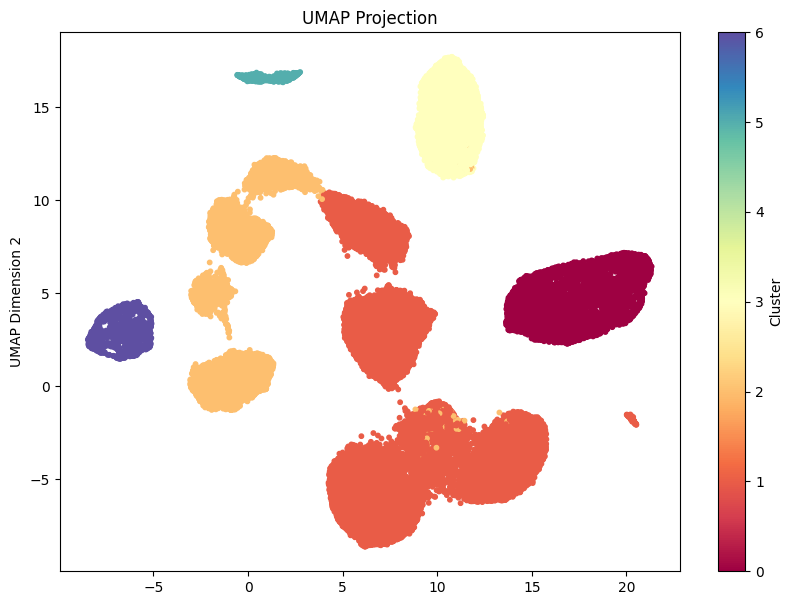

In [68]:
apply_umap(clust_apriori_sc)

### Segment Comparison

## Association Rules

We know it would be best to divide the dataset into train and test, and evaluate how well the rules describe the entire population, but due to time constraints this was not possible for us to do. In a future project, this would be something to improve on.

In [ ]:
cluster_dfs = association_rules_preproc(info_treated, basket_encoded)

for index in [0,6]:
    association_rules_apriori(cluster_dfs, index)

The higher the lift, the more specific the association rules are to the cluster at hand. To find better lift, we try lowering the minimum support